In [1]:
import scipy.optimize
from src.python.getMatrix import getMatrixByName
from src.python.vis.visMat import visMat
from src.python.vis.visGraph import visGraph
from src.python.spring_layout import spring_layout
import networkx as nx
import numpy as np
import scipy.sparse
import time

(936, 936) 6264 float64 1.0 1.0


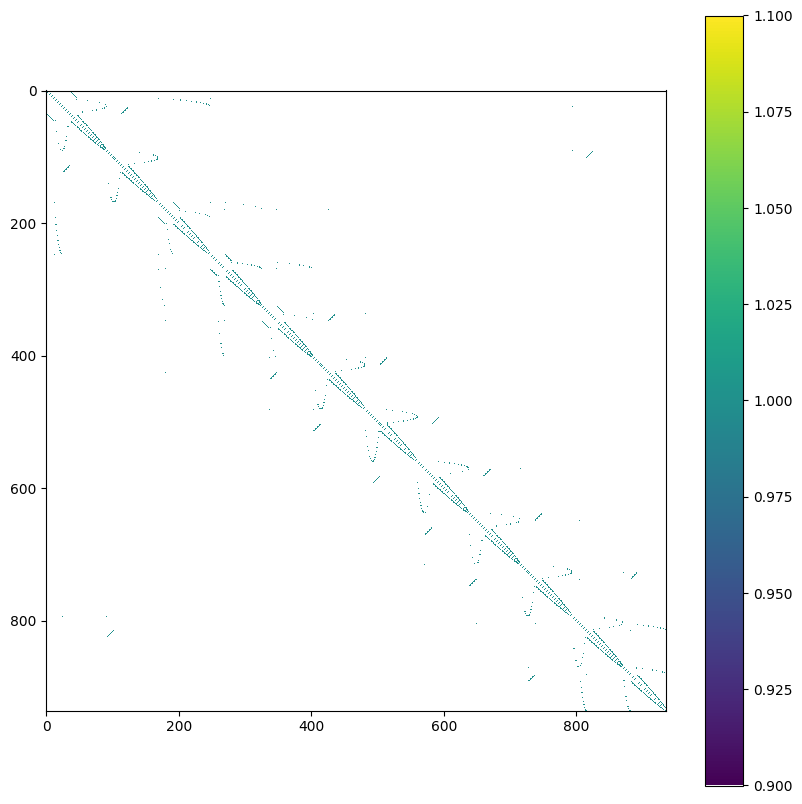

it=0
Rs=deque([], maxlen=3)
g[:3]=array([[ -4.84018324,  12.02511527],
       [-13.9740568 , -10.17527246],
       [-30.25124666, -20.88929925]])
q[:3]=array([[  4.84018324, -12.02511527],
       [ 13.9740568 ,  10.17527246],
       [ 30.25124666,  20.88929925]])
!
cost(pos,A,k)=np.float64(13633.959972266872)


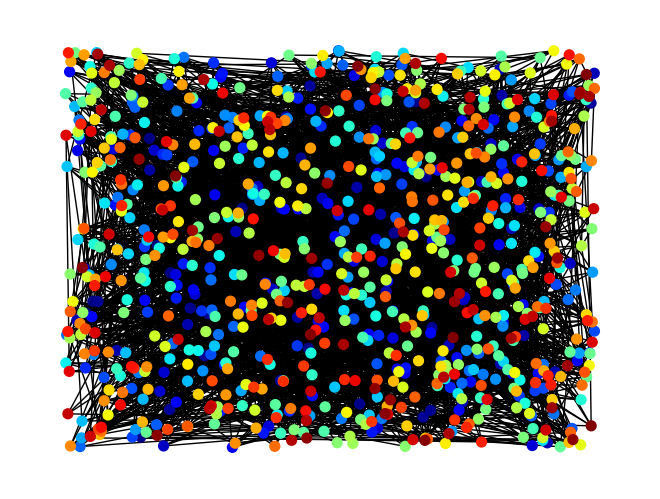

it=1
Rs=deque([], maxlen=3)
g[:3]=array([[ -4.84128742,  11.8898482 ],
       [-13.72182323, -10.07324195],
       [-29.52504641, -20.35508428]])
q[:3]=array([[  4.84128742, -11.8898482 ],
       [ 13.72182323,  10.07324195],
       [ 29.52504641,  20.35508428]])
!
cost(pos,A,k)=np.float64(13075.01827569363)


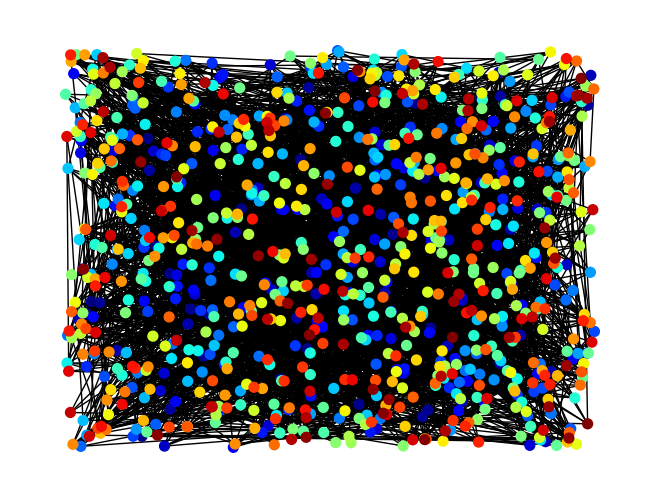

it=2
Rs=deque([np.float64(0.10212087953604103)], maxlen=3)
g[:3]=array([[ -4.84597287,  11.75105198],
       [-13.58529676,  -9.95698549],
       [-28.8325922 , -19.85516873]])
q[:3]=array([[  4.84597287, -11.75105198],
       [ 13.58529676,   9.95698549],
       [ 28.8325922 ,  19.85516873]])
cost(pos,A,k)=np.float64(46662746175.273834)


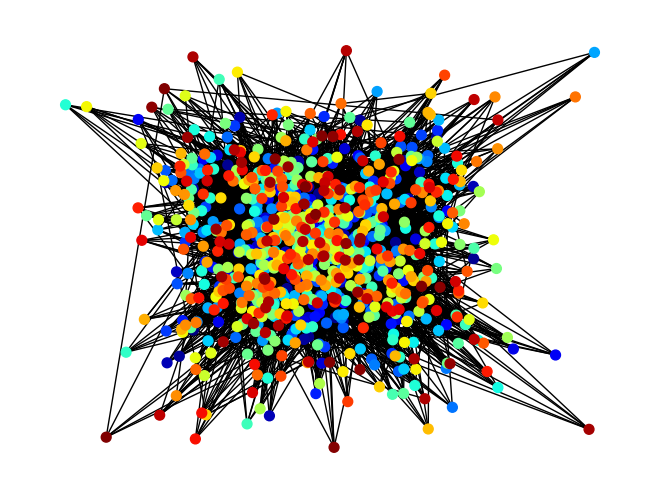

it=3
Rs=deque([np.float64(0.10212087953604103), np.float64(1.1136437889847824e-05)], maxlen=3)
g[:3]=array([[ -2963.2907282 , -36053.07325973],
       [ 31844.43046168,  40968.91156495],
       [362524.77274652, 290935.70912955]])
q[:3]=array([[   2963.2907282 ,   36053.07325973],
       [ -31844.43046168,  -40968.91156495],
       [-362524.77274652, -290935.70912955]])
cost(pos,A,k)=np.float64(1.7208598026861953e+24)


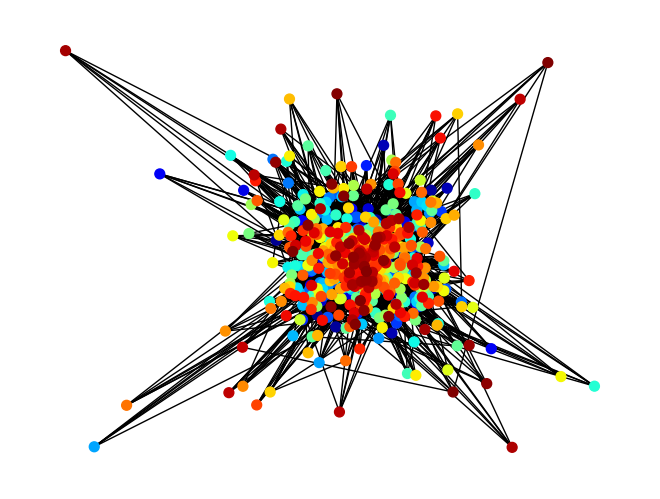

it=4
Rs=deque([np.float64(0.10212087953604103), np.float64(1.1136437889847824e-05), np.float64(-4.699897688776367e-16)], maxlen=3)
g[:3]=array([[ 3.26601462e+11,  1.40015543e+12],
       [ 2.96826935e+12,  1.97707253e+11],
       [-9.84569067e+13, -7.49883598e+13]])
q[:3]=array([[-3.26601462e+11, -1.40015543e+12],
       [-2.96826935e+12, -1.97707253e+11],
       [ 9.84569067e+13,  7.49883598e+13]])
cost(pos,A,k)=np.float64(inf)


C:\Users\hirok\Documents\University\FruchtermanReingoldByRandomSubspace\src\python\cost.py:9: RuntimeWarning: overflow encountered in power
  return (A * (distance**3) / (3 * k) - (k**2) * np.log(distance + EPS)).sum()


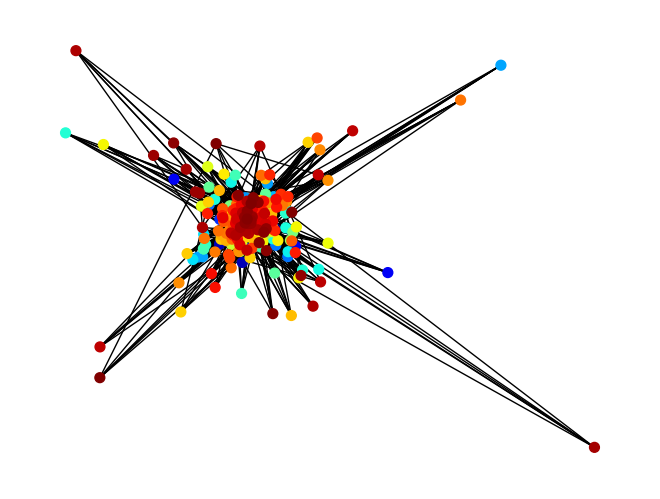

it=5
Rs=deque([np.float64(1.1136437889847824e-05), np.float64(-4.699897688776367e-16), np.float64(-2.4588760669947227e-34)], maxlen=3)
g[:3]=array([[-1.70633439e+27, -1.49663800e+28],
       [-6.39266744e+29, -2.90644381e+29],
       [ 4.78078328e+30, -7.98672716e+28]])
q[:3]=array([[ 1.70633439e+27,  1.49663800e+28],
       [ 6.39266744e+29,  2.90644381e+29],
       [-4.78078328e+30,  7.98672716e+28]])
cost(pos,A,k)=np.float64(nan)


c:\Users\hirok\Documents\University\FruchtermanReingoldByRandomSubspace\.venv\lib\site-packages\numpy\linalg\_linalg.py:2772: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\Users\hirok\Documents\University\FruchtermanReingoldByRandomSubspace\.venv\lib\site-packages\scipy\sparse\_base.py:490: RuntimeWarning: invalid value encountered in subtract
  return self.todense() - other


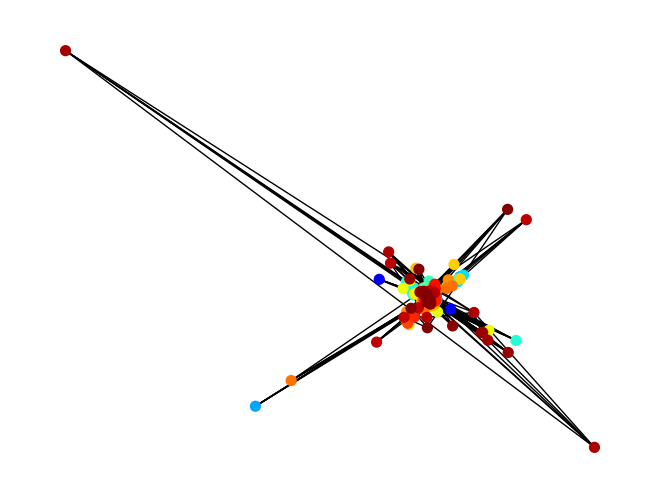

it=6
Rs=deque([np.float64(-4.699897688776367e-16), np.float64(-2.4588760669947227e-34), np.float64(-1.2302538785764464e-71)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


C:\Users\hirok\Documents\University\FruchtermanReingoldByRandomSubspace\src\python\_sparse_fr.py:154: RuntimeWarning: invalid value encountered in multiply
  coefficient1 = Ai * distance * k_inv - (k**2) * (
C:\Users\hirok\Documents\University\FruchtermanReingoldByRandomSubspace\src\python\_sparse_fr.py:157: RuntimeWarning: invalid value encountered in matmul
  g[i] = coefficient1 @ delta


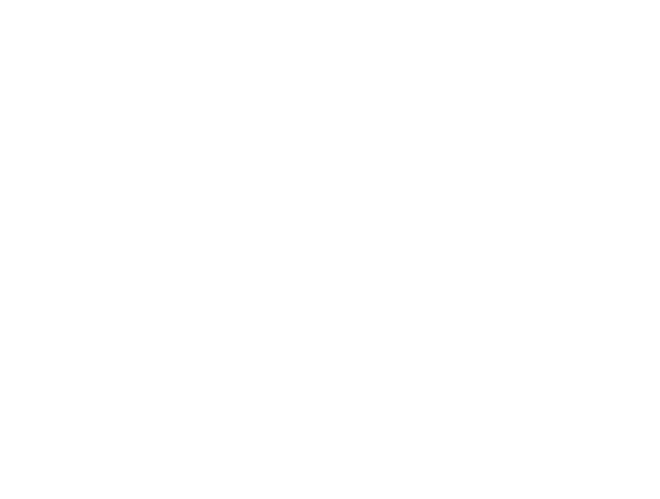

it=7
Rs=deque([np.float64(-2.4588760669947227e-34), np.float64(-1.2302538785764464e-71), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


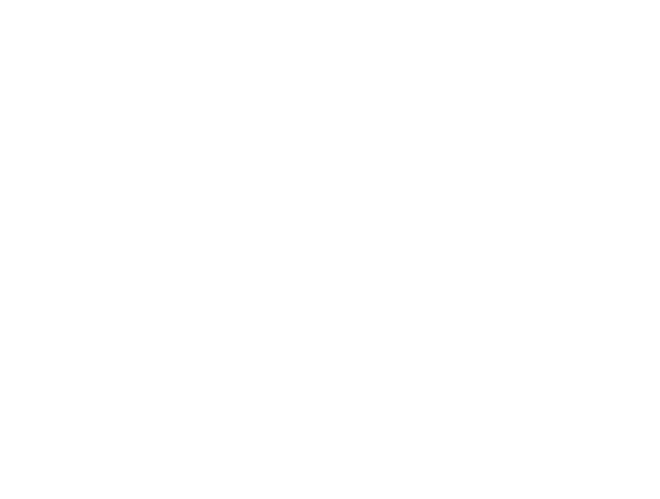

it=8
Rs=deque([np.float64(-1.2302538785764464e-71), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


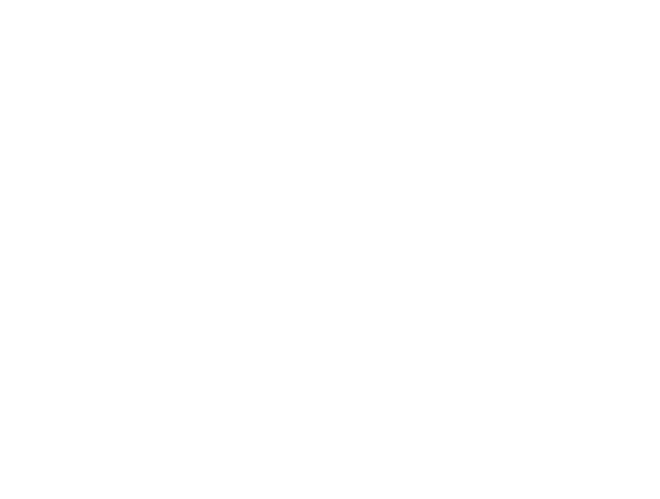

it=9
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


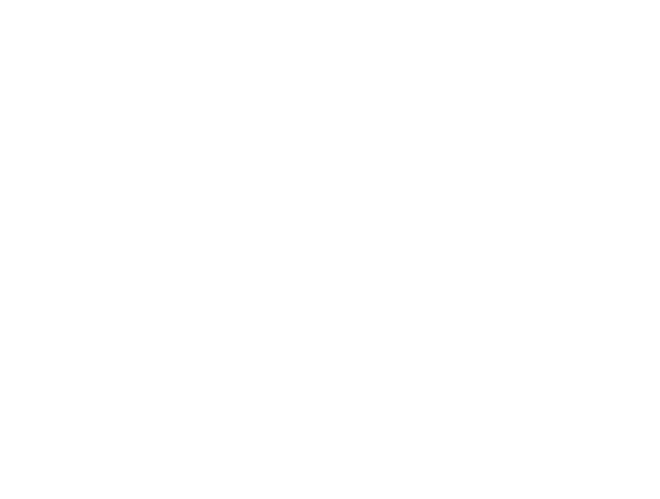

it=10
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


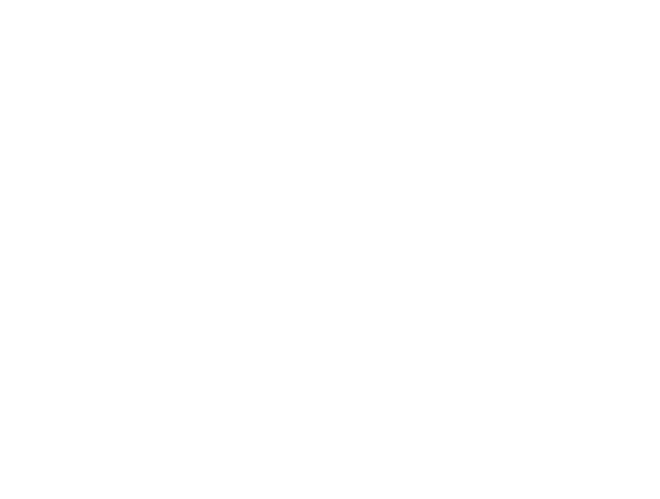

it=11
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


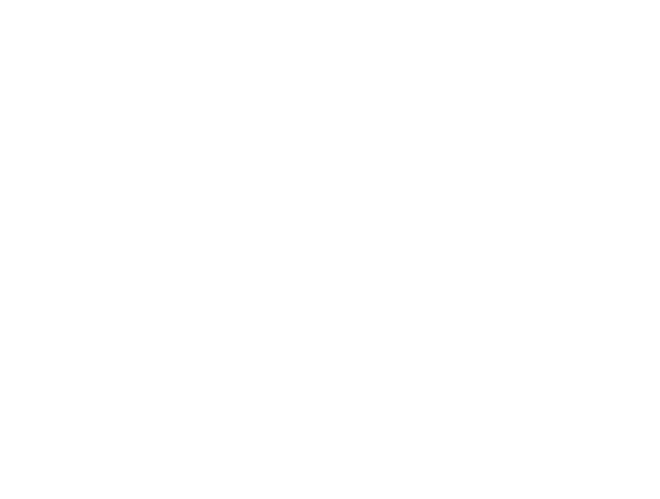

it=12
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


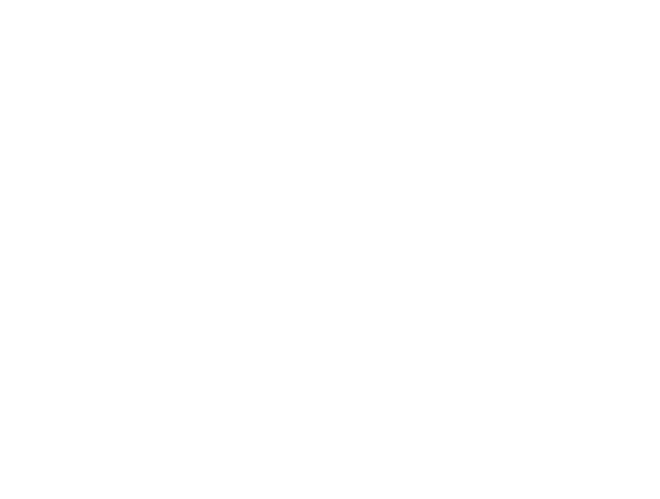

it=13
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


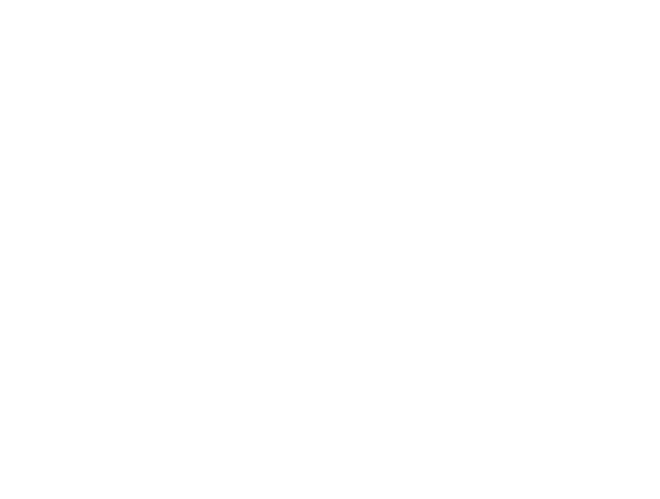

it=14
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


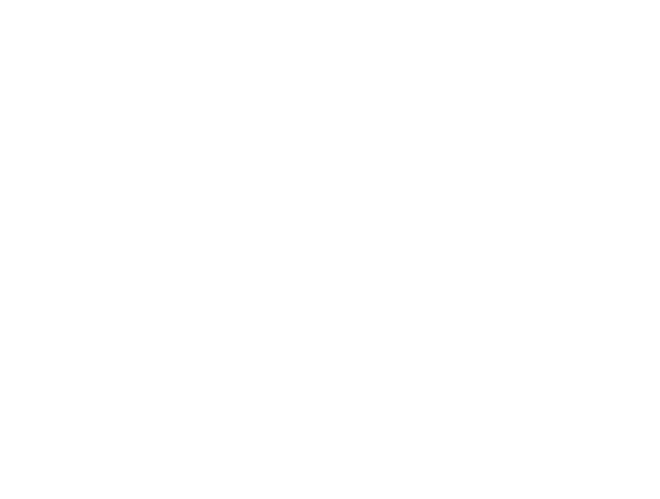

it=15
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


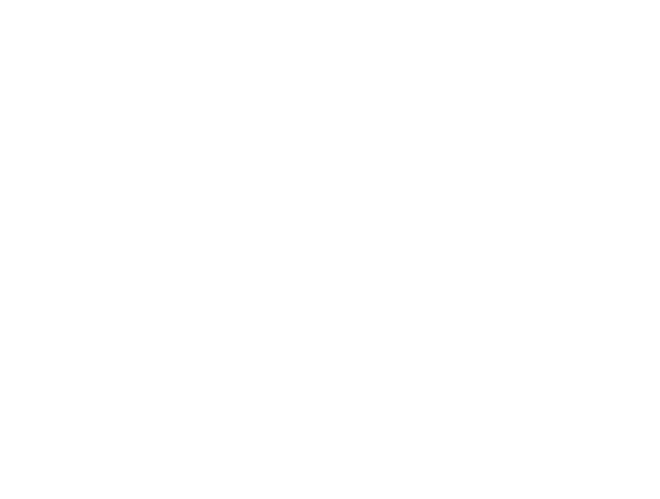

it=16
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


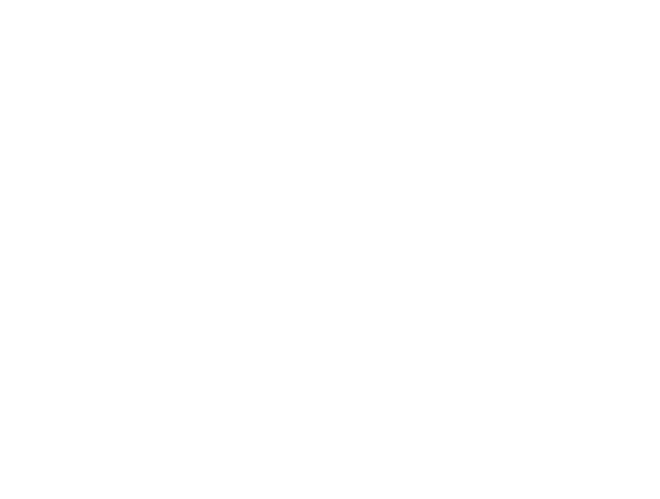

it=17
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


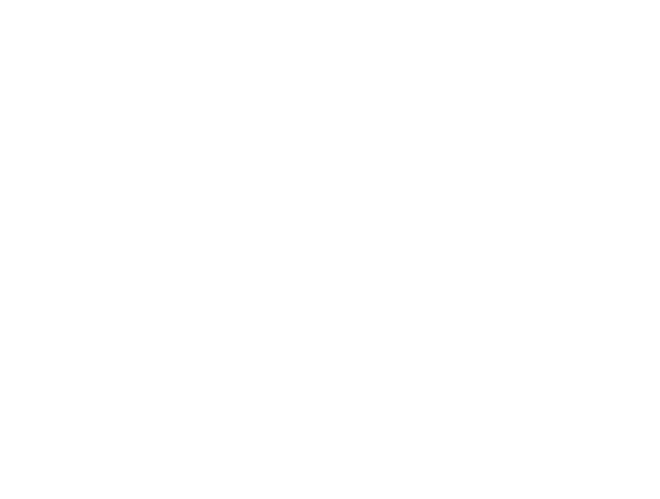

it=18
Rs=deque([np.float64(nan), np.float64(nan), np.float64(nan)], maxlen=3)
g[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
q[:3]=array([[nan, nan],
       [nan, nan],
       [nan, nan]])
cost(pos,A,k)=np.float64(nan)


KeyboardInterrupt: 

In [2]:
mat = getMatrixByName("jagmesh1")
print(mat.shape, mat.nnz, mat.dtype, np.min(mat.data), np.max(mat.data))

if scipy.sparse.issparse(mat):
    mat.setdiag(0)
    mat.eliminate_zeros()
    mat.data = np.abs(mat.data)
else:
    mat[np.diag_indices_from(mat)] = 0
    mat.data = np.abs(mat.data)

visMat(mat)


G = nx.Graph(mat)

# for pos in spring_layout(G, method="BFGS", iterations=50):
#     visGraph(G, pos)
visGraph(G, list(spring_layout(G, method="BFGS", iterations=50))[-1])

In [ ]:
# for method in [
#     "circular_layout",
#     "kamada_kawai_layout",
#     "random_layout",
#     "shell_layout",
#     "spring_layout",
#     "spectral_layout",
#     "planar_layout",
#     "spiral_layout",
#     "arf_layout",
# ]:
#     print(method)
#     t0 = time.perf_counter()
#     pos = getattr(nx, method)(G)
#     print(f"{time.perf_counter() - t0:.3f} [sec]")
#     visGraph(G, pos)

In [ ]:
import numpy as np

a = np.random.random((2, 3))
b = np.random.random((2, 3))

print(np.sum(a * b))
print(np.dot(a.flatten(), b.flatten()))

0.5396496748621
0.5396496748621
